<a href="https://colab.research.google.com/github/HugoKD/byoRNA/blob/main/ByoRna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random as rd

**Réferences :** <br>
Pour la partie DSP  :

*  Model-based design and control of a small-scale integrated (Morten Ryberg Wahlgreen et al. / IFAC PapersOnLine 55-7 (2022)
continuous end-to-end mAb platform)
*  **Modeling and Simulation of Upstream and
Downstream Processes for Monoclonal
Antibody Production**

Pour la partie USP :

*   *équations de Monod*

## POO

On va faire un poo en python pour simuler le process de filtration. Chaque filtre possède une certaine affinité, des certaines caractéristiques. On veut arriver à un résultat optimal en un nombre d'étapes minimales -> programation sous contraintes. On veut un nombre de step min et un quantité d'ARN maximale (ou alors une pureté maximale). Pour l'instant on ne considère que la taille de la molécule d'interêt. <br><br>
De base on part d'une population de x% d'ARN,y% ADN, z% débris, w% de protéines, v% de virus et p% de petites molécules -> fixé. La masse totale de la mixture,elle n'est pas fixée. Cf USP

#### USP

In [4]:
# Modèle basée sur les  équations de Monod pour simuler un process Up Stream

class USP:
    def __init__(self,taille,feed, mu_max=0.4, K_s=0.9, Y_E=0.8, q_G=0.1, q_O=0.5, m=0.01, G0=20, X0=0.4, E0=0, O0=100):
        """Initialisation de la classe USP"""
        self.mu_max = mu_max  # taux de croissance spécifique maximal (h^-1)
        self.K_s = K_s  # constante de saturation de Monod pour le glucose (g/L)
        self.Y_E = Y_E  # yield de l'éthanol sur le glucose (g/g)
        self.q_G = q_G  # taux spécifique de consommation de glucose (g/g.h)
        self.q_O = q_O  # taux spécifique de consommation d'oxygène (%/g.h)
        self.m = m  # taux de maintenance (h^-1)
        # concentrations initiales
        self.G0 = G0  # c_i de glucose (g/L)
        self.X0 = X0  # c_i de biomasse (g/L)
        self.E0 = E0  # c_i d'éthanol (g/L)
        self.O0 = O0  # c_i d'oxygène (%)
        self.solution = None  # Variable pour stocker la solution
        self.taille = taille # taille du bio réacteur (L)
        self.feed = feed

    def model(self, y, t):
        """
        Définir les équations de monod
        :param y: conditions initiales
        :param t: temps final
        :return : incrément des éq partielles
        """
        G, X, E, O = y
        mu = self.mu_max * (G / (self.K_s + G))
        dG_dt = -mu * X - self.q_G * X
        dX_dt = (mu - self.m) * X
        dE_dt = self.Y_E * (self.q_G - mu) * X
        dO_dt = -self.q_O * X
        return [dG_dt, dX_dt, dE_dt, dO_dt]

    def get_solution(self, t_end=30, n=100, plot=False):
        """
        Résoudre les eq de Monod
        :param: t_end: temps de fin
        :param: n: subdivision spatiale
        :param: plot: booléen pour afficher le graphique
        :return: G, X, E, O, respecitement les concentrations de glucose, biomasse, éthanol et oxygène
        """
        t = np.linspace(0, t_end, n)  # en heure
        y0 = [self.G0, self.X0, self.E0, self.O0]
        # Résoudre les équa diffs avec odeint
        self.solution = odeint(self.model, y0, t)
        G, X, E, O = self.solution.T
        if plot:
            # Créer le graphique
            plt.figure(figsize=(10, 6))
            plt.plot(t, G, label='Glucose')
            plt.plot(t, X, label='Biomasse')
            plt.plot(t, O, label='Oxygène (%)')
            plt.xlabel('Temps (h)')
            plt.ylabel('Concentration (g/L)')
            plt.title('Modèle de Sonnleitner et Käppeli et de Monod')
            plt.legend()
            plt.grid(True)
            plt.show()
            self.update_feed()
        else:
          self.update_feed()
          return G, X, E, O

    def get_masse_X(self):
        """
        :param: taille : en L, taille du bio réacteur
        :return: masse de biomasse en g
        """
        if self.solution is None:
            self.get_solution(plot=False)
        G, X, E, O = self.solution.T
        return X[-1] * self.taille  # return g de biomasse

    def update_feed(self):
      """
      A partir d'un feed, avec des données de base, on retourne un feed avec en plus, le nombre de chaque type de molécule, leur concentration ainsi que leur poids.
      :return: la masse de chaque molécule du feed : ADN,ARN,tiny mol, virus,debris
      """
      i = 0
      for molecule in self.feed :
        if 'pourcentage' not in molecule.keys():
          print(molecule.keys())
          raise ValueError("Feed incomplet")
        molecule['poids'] = molecule['pourcentage']*self.get_masse_X()
        molecule['concentration'] = molecule['poids']/self.taille
        molecule['nombre'] = molecule["poids"]/molecule["poids_unitaire"]
        molecule["volume"] = self.taille * molecule['pourcentage']
        self.feed[i] = molecule
        i+=1

#### Filtration par taille ou par charge

In [5]:
## Classe DSP pour simuler (fonction simulate) ou visualiser (fonction visu) un downstream process entier (plusieurs filtrations à la chaine possible)
# Simplification en proportion la masse équivaut au volume.

class DSP:

    def __init__(self, feed, temperature,filtrations):
        """
        Initialisation de la classe DSP.
        :param feed: mélange de molécules initial
        :param temperature: température de la solution
        :param filtrations: ensemble des filtrations à effectuer, une liste de dictionnaires décrivant chaque étape de filtration
        """
        self.feed = feed
        self.temperature = temperature
        self.filtrations = filtrations
        self.data = None


    def simulate(self , transform, display = True):
        """
        Simule le processus de filtration.
        :param transform: booléen indiquant si l'on transforme le feed initial ou non
        :param display: booléen indiquant si les résultats doivent être affichés.
        :return: un dictionnaire avec les résultats de la filtration.
        """
        filtration_results = self.feed
        history = []
        for filtration in self.filtrations:
            if filtration['type_filtration'] == 'size': #soit une filtration par taille
                filtration_ = Filtration(type_filtration = filtration['type_filtration'] ,feed = filtration_results,
                                         filter_size =filtration['filter_size'], filter_charge = None, pressure = filtration['pressure'],flow_rate = filtration['flow_rate'], temperature = self.temperature)
                filtration_.perform_filtration(type_ = filtration['type_'], transform = False)
            elif filtration['type_filtration'] == 'charge':#soit une filtration par charge
                filtration_ = Filtration(type_filtration = filtration['type_filtration'] ,feed = filtration_results,
                                         filter_size=None, filter_charge = filtration['filter_charge'], pressure = filtration['pressure'],flow_rate = filtration['flow_rate'], temperature = self.temperature)
                filtration_.perform_filtration(transform = False)
            elif filtration['type_filtration'] == 'chromatography':
                filtration_ = Filtration(type_filtration = 'chromatography', feed = filtration_results, temperature = self.temperature, flow_rate = filtration['flow_rate'], pressure = None)
                filtration_.perform_filtration(transform = False)
            else : raise ValueError("Type de filtration inconnu")
            filtration_results = filtration_.get_results()['filtrat']
            history.append(filtration_results)
        if display :
          print(f"initial : {self.feed}")
          print(f"filtrat: {filtration_results}")
          print(f"residu: {filtration_.get_results()['residu']}")
          self.data = {'initial' : self.feed, 'filtrat' : filtration_.get_results()['filtrat'], "residu" : filtration_.get_results()['residu'], 'history' : history}
          return self.data
        else :
          self.data = {'initial' : self.feed, 'filtrat' : filtration_.get_results()['filtrat'], "residu" : filtration_.get_results()['residu'], 'history' : history}
          return self.data

    def visu(self,transform = False):
        """
        Visualise le processus de filtration en affichant un graphique des poids des différents composants
        :param transform: booléen indiquant si l'on transforme le feed initial ou non
        :return: un dictionnaire avec les résultats de la filtration
        """
        data = self.data if self.data else self.simulate(transform)
        data = {'initial' : data['initial'], 'filtrat' : data['filtrat'], "residu" :data['residu']}
        types = ["DNA", "RNA", "protein", "virus", "tiny_mol", "debris"]
        initial_weights = [item["poids"] for item in data["initial"]]
        filtrat_weights = [item["poids"] for item in data["filtrat"]]
        residu_weights = [next((item["poids"] for item in data["residu"] if item["type"] == t), 0) for t in types]

        # Creating the bar chart
        bar_width = 0.25
        x = np.arange(len(types))

        plt.figure(figsize=(10, 6))
        plt.bar(x - bar_width, initial_weights, width=bar_width, label='Initial')
        plt.bar(x, filtrat_weights, width=bar_width, label='Filtrat')
        plt.bar(x + bar_width, residu_weights, width=bar_width, label='Residu')

        plt.xlabel('Type')
        plt.ylabel('Poids')
        plt.title('Poids par Type pour Initial, Filtrat et Residu')
        plt.xticks(x, types)
        plt.legend()
        plt.show()
        return data

    def calculate_purity(self):
        """
        Calcule l'évolution de la purété au fur et à mesure des filtrations
        : return : liste des puretés au fur et à mesure des filtrations
        """
        history = self.data['history']
        purity_history = []
        purity_history.append(next((molecule['poids'] for molecule in self.feed if molecule['type'] == 'RNA'), 0)/sum([molecule['poids'] for molecule in self.feed]))
        for stage in history:
            total_weight = sum([molecule['poids'] for molecule in stage])
            rna_weight = next((molecule['poids'] for molecule in stage if molecule['type'] == 'RNA'), 0)
            purity = (rna_weight / total_weight) * 100 if total_weight > 0 else 0
            purity_history.append(purity)

        # Creating the line chart for RNA purity
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(purity_history)), purity_history, marker='o', linestyle='-', color='b')
        plt.xlabel('Étape de filtration')
        plt.ylabel('Pureté de l\'ARN (%)')
        plt.title('Pureté de l\'ARN à travers les étapes de filtration')
        plt.grid(True)
        plt.show()

        return purity_history




In [6]:
## Classe Filtration pour simuler une seule filtration (soit une chromato par charge soit une filtration frontale pour l'instant)
# TODO : Check concentration

class Filtration:
    def __init__(self, type_filtration, feed , temperature,flow_rate,pressure, filter_charge = None, filter_size = None):
        """
        Initialise une instance de la classe Filtration
        :param type_filtration: type de filtration ('charge', 'size', 'chromatography')
        :param feed: mélange à filtrer avec divers composants
        :param temperature: température en Kelvin
        :param pressure: pression appliquée pendant la filtration
        :param flow_rate: débit à travers le filtre
        :param filter_charge: charge de la résine (pour la chromatographie par charge)
        :param filter_size: taille du filtre en nm (pour la chromatographie par taille).
        """
        self.type_filtration = type_filtration
        self.feed = feed  # Mixture to filter with various components
        self.filter_size = filter_size  # Filter size in nm (for size-based chromatography)
        self.filter_charge = filter_charge  # Resin charge (for charge-based chromatography)
        self.flow_rate = flow_rate  # Flow rate through the filter
        self.pressure = pressure  # Pressure applied during filtration
        self.temperature = temperature  # Temperature in Kelvin
        self.filtrat = []  # Fraction that passed through the filter
        self.residu = []  # Fraction that did not pass through the filter

    def perform_filtration(self, type_ = None, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=True):
        """
        Gère le type de filtration à effectuer de manière automatique
        Ajuste les constantes du modèle en fonction de l'influence des paramètres expérimentaux.
        :param type_: type de modèle de filtration ('logistique' ou 'passage')
        :param threshold: seuil pour la filtration.
        :param k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat
        """

        if self.type_filtration == 'charge':
            adjusted_k_inf = k_inf * self.flow_rate * self.pressure / self.temperature
            adjusted_k_sup = k_sup * self.flow_rate * self.pressure / self.temperature
            adjusted_threshold = threshold * self.flow_rate / self.temperature
            self.filtration_by_charge(type_, adjusted_threshold, k, adjusted_k_inf, c_inf, adjusted_k_sup, c_sup, transform)
        elif self.type_filtration == 'size':
            adjusted_k_inf = k_inf * self.flow_rate * self.pressure / self.temperature
            adjusted_k_sup = k_sup * self.flow_rate * self.pressure / self.temperature
            adjusted_threshold = threshold * self.flow_rate / self.temperature
            self.filtration_by_size(type_, threshold, k, k_inf, c_inf, k_sup, c_sup, transform)
        elif self.type_filtration == 'chromatography':
            self.filtration_with_chromatography()
        else:
            raise ValueError("Type de filtration inconnu")

    def filtration_by_charge(self, type_, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=True): # Parametres arbitraires
        """
        Effectue une filtration par charge. Par sur pour l'update de la concentration des molécules.
        :param type_: type de modèle de filtration ('logistique' ou 'passage').
        :param threshold, k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat.
        """
        P = []
        for molecule in self.feed:
            charge = molecule['charge']
            x = charge * self.filter_charge
            p = 1 / (1 + np.exp((x - threshold)))

            poids_residu = molecule["poids"] * (1 - p)
            poids_filtrat = molecule["poids"] * p

            mol_filtrat = molecule.copy()
            mol_filtrat["poids"] = poids_filtrat
            mol_filtrat["nombre"] = mol_filtrat["poids"]/mol_filtrat["poids_unitaire"]
            mol_filtrat["volume"] = mol_filtrat["volume"] *p
            self.filtrat.append(mol_filtrat)

            mol_residu = molecule.copy()
            mol_residu["poids"] = poids_residu
            mol_residu["nombre"] = mol_residu["poids"]/mol_residu["poids_unitaire"]
            mol_residu["volume"] = mol_residu["volume"] *(1-p)

            self.residu.append(mol_residu)


            total_volume_filtrat = sum(mol['volume'] for mol in self.filtrat)
            total_volume_residu = sum(mol['volume'] for mol in self.residu)
            total_volume_feed = sum(mol['volume'] for mol in self.feed)


            for mol in self.filtrat:
                mol['concentration'] = mol['poids'] / total_volume_filtrat

            for mol in self.residu:
                mol['concentration'] = mol['poids'] / total_volume_residu


            if transform:
                self.feed = self.filtrat

    def filtration_by_size(self, type_, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=True):
        """
        Effectue une filtration par taille.
        :param type_: type de modèle de filtration ('logistique' ou 'passage').
        :param threshold, k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat.
        """
        for molecule in self.feed:
            size = molecule['size']
            r = size / self.filter_size

            if size <= self.filter_size:  # Molecule smaller than the filter size
                if type_ == 'logistique':
                    p = 1 / (1 + math.exp(-k_inf * (c_inf - r)))  # Logistic function for probability
                elif type_ == 'passage':
                    p = (1 - (size / self.filter_size) ** 2) ** 1
                else:
                    raise ValueError("Type de filtre inconnu")
            else:
                if type_ == 'logistique':
                    p = 1 - 1 / (1 + math.exp(-k_sup * (r - c_sup)))  # Logistic function for probability
                elif type_ == 'passage':
                    p = 0
                else:
                    raise ValueError("Type de filtre inconnu")

            poids_residu = molecule["poids"] * (1 - p)
            poids_filtrat = molecule["poids"] * p

            mol_filtrat = molecule.copy()
            mol_filtrat["poids"] = poids_filtrat
            mol_filtrat["nombre"] = mol_filtrat["poids"]/mol_filtrat["poids_unitaire"]
            mol_filtrat["volume"] = mol_filtrat["volume"] *p

            self.filtrat.append(mol_filtrat)

            mol_residu = molecule.copy()
            mol_residu["poids"] = poids_residu
            mol_residu["nombre"] = mol_residu["poids"]/mol_residu["poids_unitaire"]
            mol_residu["volume"] = mol_residu["volume"] *(1-p)

            self.residu.append(mol_residu)


        total_volume_filtrat = sum(mol['volume'] for mol in self.filtrat)
        total_volume_residu = sum(mol['volume'] for mol in self.residu)
        total_volume_feed = sum(mol['volume'] for mol in self.feed)


        for mol in self.filtrat:
            mol['concentration'] = mol['poids'] / total_volume_filtrat

        for mol in self.residu:
            mol['concentration'] = mol['poids'] / total_volume_residu


        if transform:
            self.feed = self.filtrat

    def filtration_with_chromatography(self,L = 20,D = .01,Nx = 1000,Nt = 10000, T = 300,pulse_duration = 60
                                       ,solvent_viscosity = 0.5,epsilon_c = .4,epsilon_p = .5,pH =7.5,
                                       pI = 7.5,conductivity = .5,ligand_density = .7,particle_size = .005,elution_volume = 1, transform = False):
      #on suppose de plus une élution parfaite
      #on enchaine les chromatographie de manière 1D
      #mieux vaut re travailler le fonctionnement des classes pour n'avoir qu'a gerer ici les para de simulation et non d experimentation ! Ici on gère le fonctionnement de la chromato
      #self.filtrat ici = ce qui est retenu et résidu ce que perdu
      #on suppose que tout le liquide injecté s'est évacué

        M = []
        for molecule in self.feed :
          #molecule_size =~0.001
          chromato = Chromatography(
                L=L, temperature=self.temperature, v=self.flow_rate, affinity=molecule['affinity'],
                solvent_viscosity=solvent_viscosity, epsilon_c=epsilon_c,
                epsilon_p=epsilon_p, pH=pH, pI=pI, conductivity=conductivity,
                ligand_density=ligand_density,elution_volume = elution_volume, molecule_size = molecule["size"],particle_size = particle_size,
                D=D, Nx=Nx, Nt=Nt, pulse_duration=pulse_duration, pulse_concentration= molecule["concentration"], feed = self.feed, T = T
            )
          chromato.perform_chromatography()
          m = chromato.calculate_mass_recovered()

          M.append(m)
          print(M)
          mol_filtrat, mol_residu = molecule.copy(), molecule.copy()

          mol_filtrat["poids"] = m
          mol_filtrat["nombre"] = mol_filtrat["poids"]/mol_filtrat["poids_unitaire"]
          mol_filtrat["volume"] = chromato.elution_volume
          mol_filtrat["concentration"] = mol_filtrat["poids"]/mol_filtrat["volume"]

          self.filtrat.append(mol_filtrat)

          mol_residu["poids"] =  molecule["poids"] - M[-1]
          mol_residu["nombre"] = mol_residu["poids"]/mol_residu["poids_unitaire"]
          mol_residu["volume"] = molecule['volume']
          mol_residu["concentration"] = mol_residu["poids"]/mol_residu["volume"]

          self.residu.append(mol_residu)


        if transform :
          self.feed = self.filtrat


    def get_results(self):
        return {
            'filtrat': self.filtrat,
            'residu': self.residu
        }

total conc 67.76012713134287
target conc 67.76012713134287
purity 100.0
Final Bound Concentration: 67.76012713134287
[1.0788112725488488]
[1.0788112725488488, 1.1675394022000798]
[1.0788112725488488, 1.1675394022000798, 0.23973567353450087]
[1.0788112725488488, 1.1675394022000798, 0.23973567353450087, 0.023973565808355503]
[1.0788112725488488, 1.1675394022000798, 0.23973567353450087, 0.023973565808355503, 0.032120893711636886]
[1.0788112725488488, 1.1675394022000798, 0.23973567353450087, 0.023973565808355503, 0.032120893711636886, 0.4801306097866904]
initial : [{'type': 'DNA', 'size': 0.06, 'pourcentage': 0.45, 'poids_unitaire': 1.0956e-19, 'charge': -1, 'affinity': 0.01, 'poids': 7.968543362869099, 'concentration': 0.7968543362869098, 'nombre': 7.273223222772086e+19, 'volume': 4.5}, {'type': 'RNA', 'size': 0.05, 'pourcentage': 0.45, 'poids_unitaire': 1.9189600000000002e-19, 'charge': -1, 'affinity': 0.06, 'poids': 7.968543362869099, 'concentration': 0.7968543362869098, 'nombre': 4.152

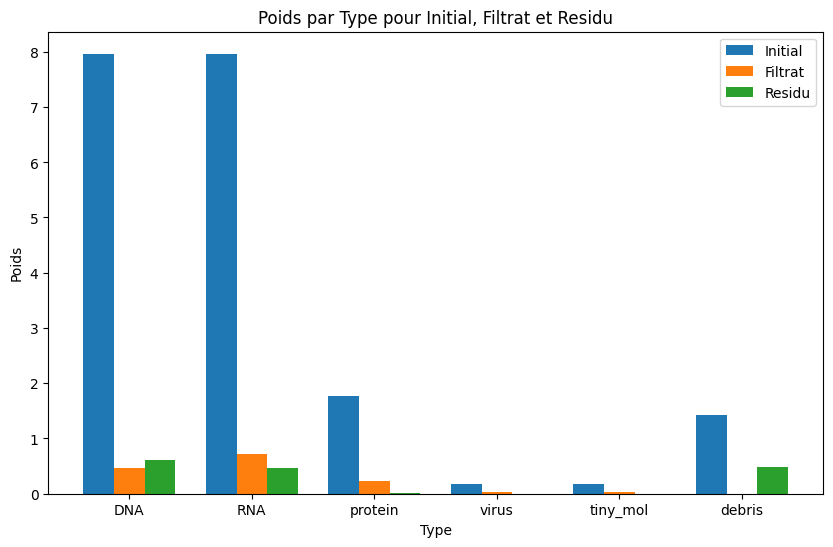

In [9]:
dalton_to_gram = 1.66e-24
taille_reacteur = 10 #(L)

feed_initial = [ #we get more info thanks to the "update_feed" method of USP class (+nbr,poids,concentration)
    {'type': 'DNA', 'size': 0.06, 'pourcentage': 0.45, 'poids_unitaire': 200 * 330 * dalton_to_gram,  'charge' : -1, 'affinity' : 0.01},
    {'type': 'RNA', 'size': 0.05, 'pourcentage': 0.45, 'poids_unitaire': 340 * 340 * dalton_to_gram, 'charge' : -1, 'affinity' :  0.06},
    {'type': 'protein', 'size': 0.02, 'pourcentage': 0.10, 'poids_unitaire': 108 * 110 * dalton_to_gram,  'charge' : 2, 'affinity' : 0.01},
    {'type': 'virus', 'size': 0.01, 'pourcentage': 0.01, 'poids_unitaire': 100 * 10**9 * dalton_to_gram, 'charge' : 0, 'affinity' :  0.01},
    {'type': 'tiny_mol', 'size': 0.001, 'pourcentage': 0.01, 'poids_unitaire': 1 * 180 * dalton_to_gram,  'charge' : -1, 'affinity' :  0.005},
    {'type': 'debris', 'size': 0.1, 'pourcentage': 0.08, 'poids_unitaire': 200 * 5000 * dalton_to_gram, 'charge' : 0, 'affinity' : 0.001}
]

usp = USP(feed = feed_initial, taille = taille_reacteur)
G, X, E, O = usp.get_solution(plot=False)

#print(f"masse totale USP de {usp.get_masse_X()}")
#print([f"{molecule['type']} {molecule['charge']}" for molecule in feed_initial])
#print(usp.feed)

process = DSP(
    usp.feed,
    temperature=293.15,
    filtrations =  [
    {'type_filtration': 'chromatography',
    'filter_size': 300,
    'type_' : 'passage',
    'flow_rate' : 0.1,
    },
    {'type_filtration': 'size',
    'filter_size': 0.08,
    'type_' : 'passage',
    'flow_rate' : 1.5,
    'pressure' : 2}
])

''''

                   ,
    {'type_filtration': 'size',
    'filter_size': 300,
    'type_' : 'passage',
    'flow_rate' : 1.5,
    'pressure' : 2},
    {
    'type_filtration': 'charge',
    'filter_charge': -1,
    'flow_rate' : 1.5,
    'pressure' : 2,}
'''

s = process.visu()

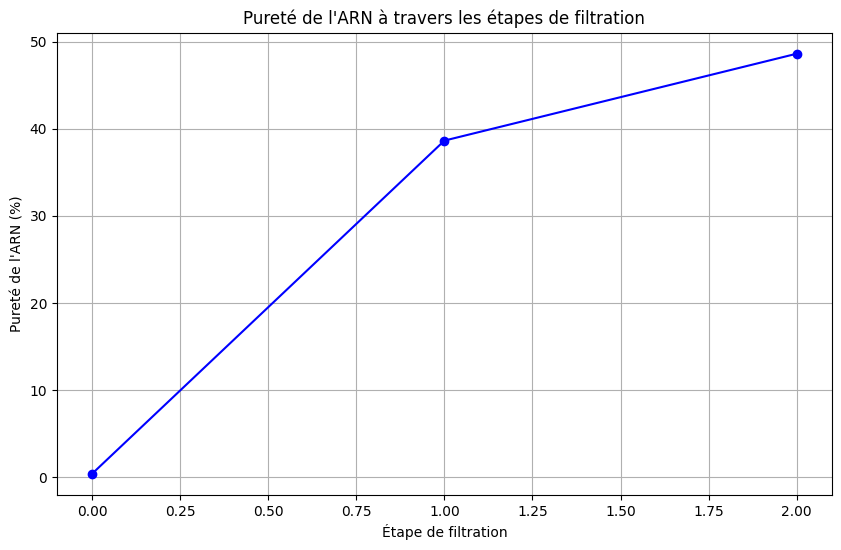

[0.40909090909090917, 38.63067834124902, 48.600409871247216]

In [10]:
process.calculate_purity()

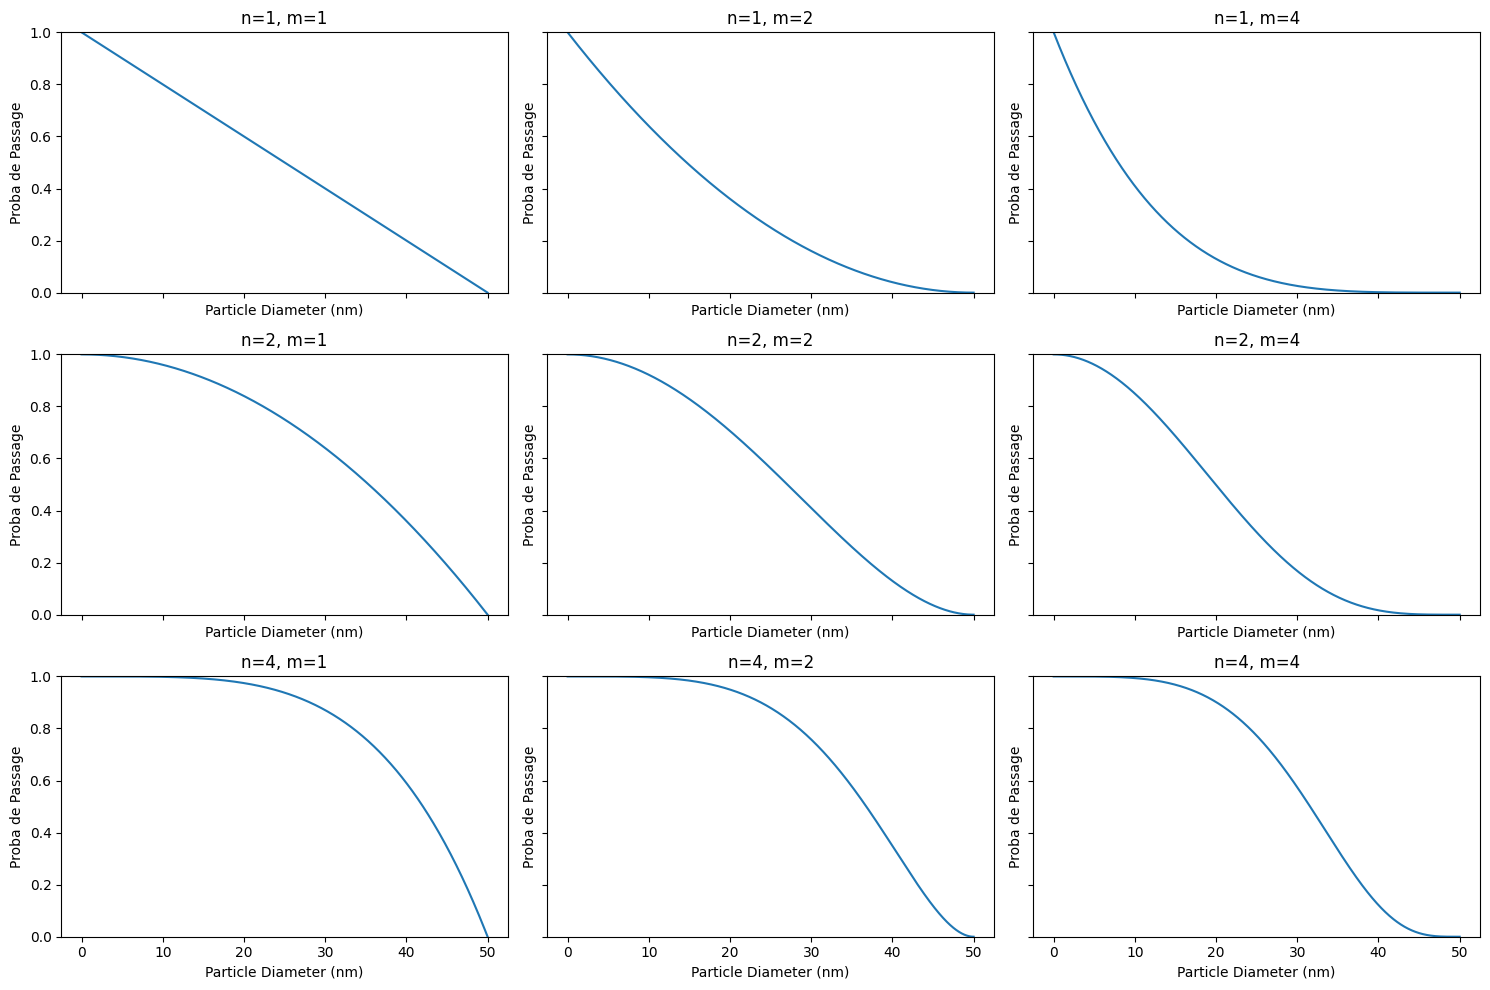

In [11]:
"""Influence des paramètres n et m sur la fonction de passage"""

def passage_probability(pore_diameter, particle_diameter, n, m):
    return (1 - (particle_diameter / pore_diameter) ** n) ** m

pore_diameter = 50  # 50 nm

particle_diameters = np.linspace(0, 50, 1000)  # De 1 nm à 100 nm

# Différentes valeurs de n et m
ns = [1, 2, 4]
ms = [1, 2, 4]

fig, ax = plt.subplots(len(ns), len(ms), figsize=(15, 10), sharex=True, sharey=True)

for i, n in enumerate(ns):
    for j, m in enumerate(ms):
        probabilities = [passage_probability(pore_diameter, d, n, m) for d in particle_diameters]
        ax[i, j].plot(particle_diameters, probabilities)
        ax[i, j].set_title(f'n={n}, m={m}')
        ax[i, j]
        ax[i, j].set_ylim(0, 1)
        ax[i, j].set_xlabel('Particle Diameter (nm)')
        ax[i, j].set_ylabel('Proba de Passage')

plt.tight_layout()
plt.show()


#### Modélisation chromato basée sur les équations de transfert de masse

Explenation of each term (cf *Integrated design of biopharmaceutical manufacturing processes:
Operation modes and process conﬁgurations for monoclonal antibody
production* paper) :


*   **c: Concentration of the bulk liquid phase.**

    This refers to the concentration of the solute or substance in the main liquid stream that is flowing through the column.


*   **cp: Intra-particle liquid phase concentration.**

    concentration of the solute inside the porous particles of the column, which may differ from the bulk concentration due to mass transfer processes.

*  **εp: Particle porosity.**

    fraction of the particle volume that is not occupied by the solid phase (ie resin) inside the column particles.

*   **εc: Column porosity.**

    This parameter represents the fraction of the column volume that is occupied by the liquid phase.


*   rp: Particle radius.

    The radius of the porous particles within the column.











Colonne NatrixQ, capture au niveau de la résine les molécules d'interêts qui sont llibérées après élution <br>
Critère du Ph < 7.5

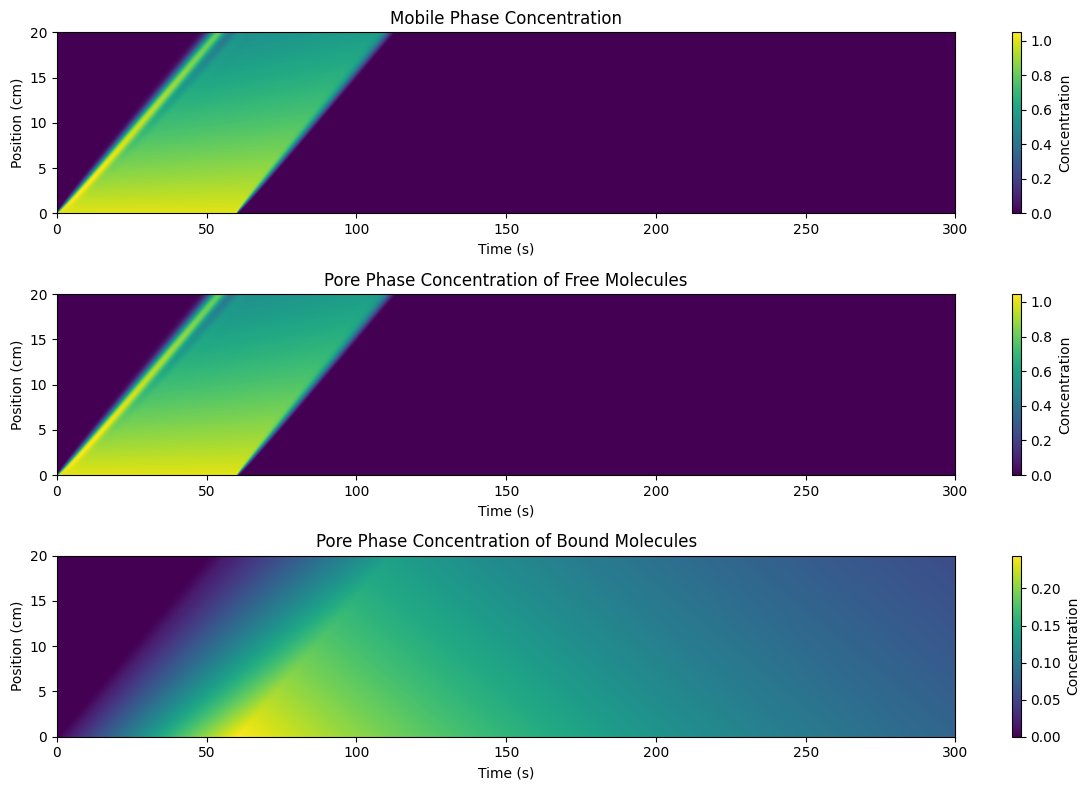

In [8]:
# Probleme ne considère pas l'interraction avec les autres molécules
# Fait fit des problèmes de competitivité, pb?
# Le code ne traite qu'un seul composant sans interaction compétitive, ce qui est une simplification par rapport au GRM.
# Pas de diffusion radiale ni gradient radial
# amélioration : GRM
class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, particle_size, temperature, solvent_viscosity,
                 affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size,elution_volume):

        super().__init__(feed=feed, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = molecule_size  # to help determine the opti ligand density
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand
        self.pI = pI   # point isoélectrique de la molécule
        self.elution_volume = elution_volume

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant ainsi que de la taille de la molécule
        Formule dérivée de la loi de Stijes-Einstein
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores
        """
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        """
        Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
        """
        ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
        surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
        max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
        return max_ligand_density

    def calculate_affinity_factor(self):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand
        :return: facteur d'affinité ajusté.
        """
        affinity_base = self.affinity * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
        charge_effect = 1 if abs(self.pH - self.pI) < 1 else 0.8
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity)) * charge_effect
        return affinity_


    def calculate_R(self, c, cp, q):
        """
        Calcule le taux de transport du volume de liquide mobile (bulk phase) au volume des pores des particules
         (?transfer of molecules from the mobile phase into the pores of the particles)
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction R
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        """
        Calcule le taux de transport des molécules dans le volume libre (unbound ou free) à l'intérieur des pores des particules
        Représente les molécules entrant ou sortant de l'espace poreux où elles ne sont pas liées à la phase stationnaire
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction Rp
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        """
        Calcule le taux de transport des molécules vers l'état lié dans le volume des pores de la particule.
        => Correspond à l'adsorption (ou à la désorption) des molécules sur (ou depuis) ​​les ligands dans les pores de la particule
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rq.
        """
        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        """
        Calcule le terme de réaction rp pour la phase mobile
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre
        :return: terme de réaction rp
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (c - cp)

    def calculate_rq(self, cp, q):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction rq
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (cp - q)

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            #print(f"Time: {t}, c[0]: {self.c[0]}, c[-1]: {self.c[-1]}")
            #print(f"q[0]: {self.q[0]}, q[-1]: {self.q[-1]}")
            #print(f"affinity_factor: {self.calculate_affinity_factor()}")

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())


    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def plot_loading_phase(self):
        """
        Plots the loading phase showing the mobile phase concentration at the outlet and the total mAbs captured.
        """
        outlet_history = np.array(self.outlet_history)
        total_mAbs_captured = np.array([np.sum(q) for q in self.q_history])

        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Outlet Concentration', color='tab:blue')
        ax1.plot(np.linspace(0, self.T, len(outlet_history)), outlet_history, color='tab:blue', label='Outlet Concentration')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.axvline(x=self.pulse_duration, color='red', linestyle='--', label='End of Loading Phase')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Total mAbs Captured', color='tab:green')
        ax2.plot(np.linspace(0, self.T, len(total_mAbs_captured)), total_mAbs_captured, color='tab:green', label='Total mAbs Captured')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        fig.tight_layout()
        plt.title('Loading Phase')
        fig.legend(loc='upper right')
        plt.show()


    def get_final_bound_concentration(self):
        """
        Retourne la concentration totale des molécules cibles qui sont restées accrochées dans la colonne.
        """
        return np.sum(self.q)

    def calculate_mass_recovered(self):
        """
        Calcule la masse totale des molécules cibles récupérées dans la colonne
        """
        mass_recovered = np.trapz(self.q, dx=self.dx)
        return mass_recovered

    def get_yield(self):
        """
        Calcule le rendement du processus de chromatographie en comparant la masse récupérée à la masse injectée
        """
        mass_recovered = self.calculate_mass_recovered()
        mass_injected = self.pulse_concentration * self.pulse_duration * self.v
        return mass_recovered / mass_injected


    def calculate_purity(self):
        """
        Calcule la pureté de la molécule cible dans la fraction collectée.
        """
        total_concentration = np.sum(self.c) + np.sum(self.cp) + np.sum(self.q)
        target_concentration = np.sum(self.q)
        print(f'total conc {total_concentration}')
        print(f'target conc {target_concentration}')
        if total_concentration == 0:
            return 0.0

        purity = (target_concentration / total_concentration) * 100
        return purity



    def calculate_purity_(self):
        """
        Calcule la pureté de la molécule cible dans la fraction collectée.
        """
        # Intégration des concentrations sur la longueur de la colonne
        total_concentration = np.trapz(self.c, dx=self.dx) + np.trapz(self.cp, dx=self.dx) + np.trapz(self.q, dx=self.dx)
        target_concentration = np.trapz(self.q, dx=self.dx)
        print(f'total conc_ {total_concentration}')
        print(f'target conc_ {target_concentration}')
        if total_concentration == 0:
            return 0.0

        purity = (target_concentration / total_concentration) * 100
        return purity

feed = feed_initial

particle_size = 0.005
molecule_size = 0.001
L = 20
T = 300.0
v = 0.1
D = 0.01
Nx = 1000
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
temperature = 293.15
solvent_viscosity = 0.5
affinity = 0.01
epsilon_c = 0.4
epsilon_p = 0.5
pH = 7.5
pI = 7.5
conductivity = 0.5
ligand_density = 0.7
elution_volume = 1 #L

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI = pI,
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_size=molecule_size,
    elution_volume = elution_volume
)

chromato.perform_chromatography()
chromato.plot_result()
final_bound_concentration = chromato.get_final_bound_concentration()
print(f"purity {chromato.calculate_purity()}")
print(f"Final Bound Concentration: {final_bound_concentration}")

In [ ]:
m,y =chromato.calculate_mass_recovered(), chromato.get_yield()
print(m,y)

1.3538364407455608 0.22563940679092678


## TEST

In [ ]:
feed_initial = [ #we get more info thanks to the "update_feed" method of USP class (+nbr,poids,concentration)
    {'type': 'DNA', 'size': 200, 'pourcentage': 0.45, 'poids_unitaire': 200 * 330 * dalton_to_gram,  'charge' : -1, 'affinity' : 0.04},
    {'type': 'RNA', 'size': 340, 'pourcentage': 0.45, 'poids_unitaire': 340 * 340 * dalton_to_gram, 'charge' : -1, 'affinity' : 0.1},
    {'type': 'protein', 'size': 108, 'pourcentage': 0.10, 'poids_unitaire': 108 * 110 * dalton_to_gram,  'charge' : 2, 'affinity' : 0.02},
    {'type': 'virus', 'size': 100, 'pourcentage': 0.01, 'poids_unitaire': 100 * 10**9 * dalton_to_gram, 'charge' : 0, 'affinity' : 0.01},
    {'type': 'tiny_mol', 'size': 10, 'pourcentage': 0.01, 'poids_unitaire': 1 * 180 * dalton_to_gram,  'charge' : -1, 'affinity' : 0.007},
    {'type': 'debris', 'size': 1000, 'pourcentage': 0.08, 'poids_unitaire': 200 * 5000 * dalton_to_gram, 'charge' : 0, 'affinity' : 0.02}
]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Filtration:
    def __init__(self, feed, filter_size):
        self.feed = feed
        self.filter_size = filter_size

class Chromatography(Filtration):
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity, epsilon_c, epsilon_p):
        super().__init__(feed, filter_size)
        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # velocité linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion  (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.target_molecule = target_molecule  # molécule d'intérêt
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = molecule_size  # taille des molécules
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_open_surface_area(self):
        return 6 / self.particle_size

    def calculate_R(self, c, cp, q):
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        phi_p = self.calculate_open_surface_area()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        return self.affinity * (c - cp)

    def calculate_rq(self, cp, q):
        return self.affinity * (cp - q)

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = (self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = (self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = (self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def get_final_bound_concentration(self):
        return self.q[-1]

# Initialize the Chromatography with the given parameters
particle_size = 0.005
molecule_size = 5e-05
L = 10
T = 200.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0
temperature = 293.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 0.1  # Example solvent viscosity (arbitrary units)
affinity = 0.01  # Example affinity constant
epsilon_c = 0.4  # Porosity of the column
epsilon_p = 0.5  # Porosity of the particles

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    target_molecule=target_molecule,
    feed=feed,
    filter_size=filter_size,
    particle_size=particle_size,
    molecule_size=molecule_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p
)
chromato.perform_chromatography()
chromato.plot_result()
final_bound_concentration = chromato.get_final_bound_concentration()
print("Final bound concentration:", final_bound_concentration)


TypeError: 'tuple' object does not support item assignment

In [ ]:
particle_size = 0.005
molecule_size = 5e-05
temperature = 293.15
solvent_viscosity =  1.2
affinity =  0.01
epsilon_c =  0.3
epsilon_p  = 0.5
L = 10
T = 2000.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

Best Parameters:
{'particle_size': 0.005, 'molecule_size': 5e-05, 'temperature': 293.15, 'solvent_viscosity': 1.2, 'affinity': 0.01, 'epsilon_c': 0.3, 'epsilon_p': 0.5} <br>
Best Bound Molecule Concentration:
2.7663912297019095e+83


In [ ]:
L = 10
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

particle_sizes = [0.005, 0.01, 0.02]
molecule_sizes = [0.00005, 0.0001, 0.0002]
temperatures = [298.15]
solvent_viscosities = [0.8, 1, 1.2]
affinities = [0.005, 0.01, 0.02]
epsilon_cs = [0.3, 0.4, 0.5]
epsilon_ps = [0.3, 0.4, 0.5]
pH_values = [7.5]
conductivities = [0.0, 0.5]  # Including different conductivities
ligand_densities = [0.1, 0.5, 1.0]  # Including different ligand densities
best_bound_concentration = 0
best_parameters = {}

for particle_size in particle_sizes:
    for molecule_size in molecule_sizes:
        for temperature in temperatures:
            for solvent_viscosity in solvent_viscosities:
                for affinity in affinities:
                    for epsilon_c in epsilon_cs:
                        for epsilon_p in epsilon_ps:
                            for pH in pH_values:
                                for conductivity in conductivities:
                                    for ligand_density in ligand_densities:
                                        # Instantiate and run chromatography
                                        chromatography = Chromatography(
                                            feed=feed,
                                            filter_size=filter_size,
                                            L = L,
                                            T = T,
                                            v = v,
                                            D = D,
                                            Nx = Nx,
                                            Nt = Nt,
                                            pulse_duration = pulse_duration,
                                            pulse_concentration = pulse_concentration,
                                            particle_size = particle_size,
                                            temperature = temperature,
                                            solvent_viscosity = solvent_viscosity,
                                            affinity = affinity,
                                            epsilon_c = epsilon_c,
                                            epsilon_p = epsilon_p,
                                            pH = pH,
                                            conductivity = conductivity,
                                            ligand_density = ligand_density
                                        )
                                        chromatography.perform_chromatography()
                                        final_bound_concentration = chromatography.get_final_bound_concentration()

                                        if final_bound_concentration > best_bound_concentration:
                                            best_bound_concentration = final_bound_concentration
                                            best_parameters = {
                                                'particle_size': particle_size,
                                                'molecule_size': molecule_size,
                                                'temperature': temperature,
                                                'solvent_viscosity': solvent_viscosity,
                                                'affinity': affinity,
                                                'epsilon_c': epsilon_c,
                                                'epsilon_p': epsilon_p,
                                                'pH': pH,
                                                'conductivity': conductivity,
                                                'ligand_density': ligand_density
                                            }

print("Best Parameters:")
print(best_parameters)
print("Best Bound Molecule Concentration:")
print(best_bound_concentration)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1238: RuntimeWarning: overflow encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
<ipython-input-51-d10a70c4b95a>:87: RuntimeWarning: overflow encountered in multiply
  return -phi_l * rp
<ipython-input-51-d10a70c4b95a>:143: RuntimeWarning: invalid value encountered in subtract
  dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
<ipython-input-51-d10a70c4b95a>:100: RuntimeWarning: overflow encountered in multiply
  return phi_p * rp + rq
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1238: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1266: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
<ipython-inp

Best Parameters:
{'particle_size': 0.005, 'molecule_size': 5e-05, 'temperature': 298.15, 'solvent_viscosity': 1.2, 'affinity': 0.01, 'epsilon_c': 0.3, 'epsilon_p': 0.5, 'pH': 7.5, 'conductivity': 0.5, 'ligand_density': 1.0}
Best Bound Molecule Concentration:
1.410834601158192e+294


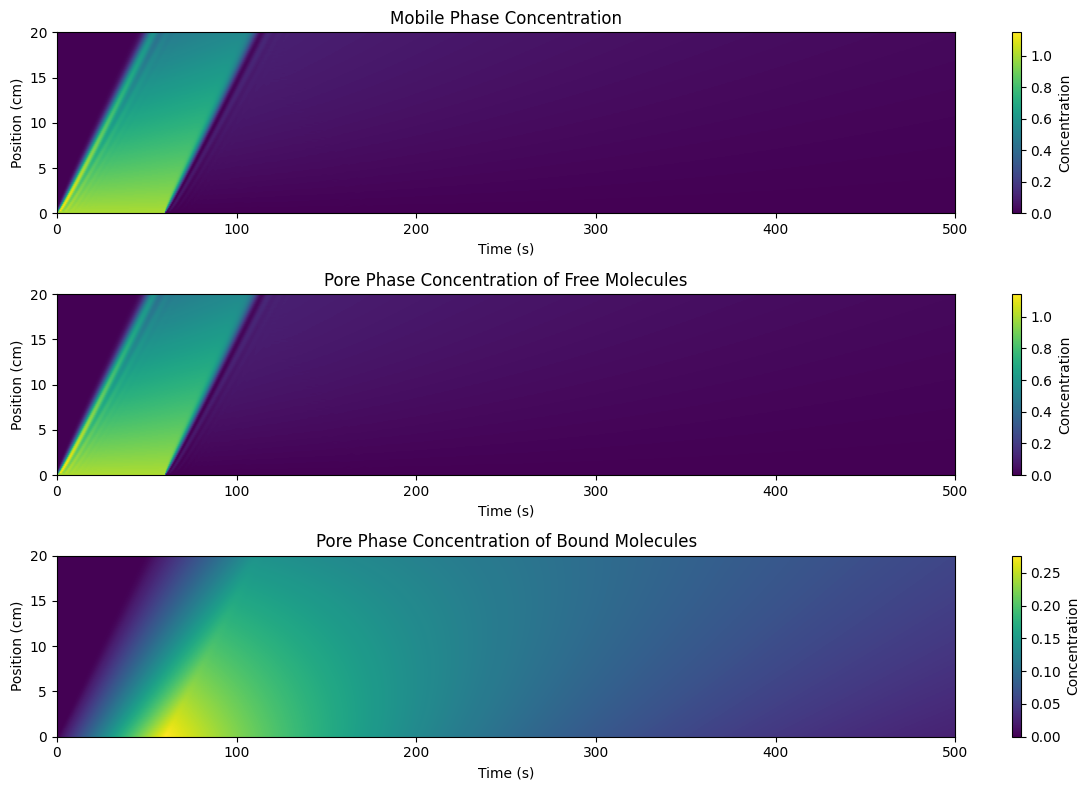

Final bound concentration: 4.333358203039171


In [ ]:
class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, filter_size, particle_size, temperature, solvent_viscosity,
                 affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size):
        super().__init__(feed=None, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = molecule_size  # for the ligand density
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand
        self.pI = pI   # point isoélectrique de la molécule

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant
        :return: coefficient de diffusion ajusté.
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores
        """
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        """
        Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
        """
        ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
        surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
        max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
        return max_ligand_density

    def calculate_affinity_factor(self):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand
        :return: facteur d'affinité ajusté.
        """
        if abs(self.pH - self.pI) < 1:
            charge_effect = 0.2  # Molécule partiellement neutre
        elif self.pH > self.pI:
            charge_effect = 0.8  # Molécule négative
        else:
            charge_effect = 0.8  # Molécule positive
        affinity_base = self.affinity * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity))
        return affinity_ #* charge_effect


    def calculate_R(self, c, cp, q):
        """
        Calcule le taux de transport R pour la phase mobile
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction R
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        """
        Calcule le taux de transport des free molecules Rp pour la phase libre dans les pores.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rp.
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        """
        Calcule le taux de transport des molécules liées Rq pour la phase liée dans les pores.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rq.
        """
        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        """
        Calcule le terme de réaction rp pour la phase mobile.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :return: terme de réaction rp.
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (c - cp)

    def calculate_rq(self, cp, q):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction rq.
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (cp - q)

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse.
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())


    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def get_final_bound_concentration(self):
        """
        Retourne la concentration totale des molécules cibles qui sont restées accrochées dans la colonne.
        """
        return np.sum(self.q)

    def calculate_mass_recovered(self):
        """
        Calcule la masse totale des molécules cibles récupérées dans la colonne.
        """
        mass_recovered = np.trapz(self.q, dx=self.dx)
        return mass_recovered

    def get_yield(self):
        """
        Calcule le rendement du processus de chromatographie en comparant la masse récupérée à la masse injectée.
        """
        mass_recovered = self.calculate_mass_recovered()
        mass_injected = self.pulse_concentration * self.pulse_duration * self.v
        return mass_recovered / mass_injected


# Example usage:

feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

particle_size = 0.005
molecule_size = 0.001
L = 20
T = 500.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
temperature = 293.15
solvent_viscosity = 0.5
affinity = 0.01
epsilon_c = 0.4
epsilon_p = 0.5
pH = 7.5
pI = 7.5
conductivity = 0.3
ligand_density = 0.7

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    filter_size=filter_size,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI = pI,
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_size=molecule_size
)

chromato.perform_chromatography()
chromato.plot_result()
final_bound_concentration = chromato.get_final_bound_concentration()
print("Final bound concentration:", final_bound_concentration)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, filter_size, particle_size, temperature, solvent_viscosity,
                 affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size):

        super().__init__(feed=feed, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = molecule_size  # to help determine the opti ligand density
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand
        self.pI = pI   # point isoélectrique de la molécule

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]
        self.outlet_history = []  # To track the outlet concentration

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant ainsi que de la taille de la molécule
        Formule dérivée de la loi de Stijes-Einstein
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores
        """
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        """
        Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
        """
        ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
        surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
        max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
        return max_ligand_density

    def calculate_affinity_factor(self):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand
        :return: facteur d'affinité ajusté.
        """
        affinity_base = self.affinity * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
        charge_effect = 1 if abs(self.pH - self.pI) < 1 else 0.8
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity)) * charge_effect
        return affinity_

    def calculate_R(self, c, cp, q):
        """
        Calcule le taux de transport du volume de liquide mobile (bulk phase) au volume des pores des particules
         (?transfer of molecules from the mobile phase into the pores of the particles)
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction R
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        """
        Calcule le taux de transport des molécules dans le volume libre (unbound ou free) à l'intérieur des pores des particules
        Représente les molécules entrant ou sortant de l'espace poreux où elles ne sont pas liées à la phase stationnaire
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction Rp
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        """
        Calcule le taux de transport des molécules vers l'état lié dans le volume des pores de la particule.
        => Correspond à l'adsorption (ou à la désorption) des molécules sur (ou depuis) ​​les ligands dans les pores de la particule
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rq.
        """
        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        """
        Calcule le terme de réaction rp pour la phase mobile
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre
        :return: terme de réaction rp
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (c - cp)

    def calculate_rq(self, cp, q):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction rq
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (cp - q)

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())
            self.outlet_history.append(self.c[-1])  # Track outlet concentration

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def plot_loading_phase(self):
        """
        Plots the loading phase showing the mobile phase concentration at the outlet and the total mAbs captured.
        """
        outlet_history = np.array(self.outlet_history)
        total_mAbs_captured = np.array([np.sum(q) for q in self.q_history])

        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Outlet Concentration', color='tab:blue')
        ax1.plot(np.linspace(0, self.T, len(outlet_history)), outlet_history, color='tab:blue', label='Outlet Concentration')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.axvline(x=self.pulse_duration, color='red', linestyle='--', label='End of Loading Phase')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Total mAbs Captured', color='tab:green')
        ax2.plot(np.linspace(0, self.T, len(total_mAbs_captured)), total_mAbs_captured, color='tab:green', label='Total mAbs Captured')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        fig.tight_layout()
        plt.title('Loading Phase')
        fig.legend(loc='upper right')
        plt.show()

    def plot_recovery_phase(self):
        """
        Plots the recovery phase showing the mAbs concentration in the collector and the total mAbs in the collector.
        """
        recovery_start = int(self.pulse_duration / self.dt)
        mAbs_in_collector = [np.sum(q[recovery_start:]) for q in self.q_history]

        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('mAbs Concentration in Collector', color='tab:blue')
        ax1.plot(np.linspace(0, self.T, len(mAbs_in_collector)), mAbs_in_collector, color='tab:blue', label='mAbs in Collector')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.axvline(x=self.T, color='red', linestyle='--', label='End of Recovery Phase')

        fig.tight_layout()
        plt.title('Recovery Phase')
        fig.legend(loc='upper right')
        plt.show()

    def get_final_bound_concentration(self):
        """
        Retourne la concentration totale des molécules cibles qui sont restées accrochées dans la colonne.
        """
        return np.sum(self.q)

    def calculate_mass_recovered(self):
        """
        Calcule la masse totale des molécules cibles récupérées dans la colonne
        """
        mass_recovered = np.trapz(self.q, dx=self.dx)
        return mass_recovered

    def get_yield(self):
        """
        Calcule le rendement du processus de chromatographie en comparant la masse récupérée à la masse injectée
        """
        mass_recovered = self.calculate_mass_recovered()
        mass_injected = self.pulse_concentration * self.pulse_duration * self.v
        return mass_recovered / mass_injected

    def calculate_purity(self):
        """
        Calcule la pureté de la molécule cible dans la fraction collectée.
        """
        total_concentration = np.sum(self.c) + np.sum(self.cp) + np.sum(self.q)
        target_concentration = np.sum(self.q)
        if total_concentration == 0:
            return 0.0

        purity = (target_concentration / total_concentration) * 100
        return purity

    def calculate_purity_(self):
        """
        Calcule la pureté de la molécule cible dans la fraction collectée.
        """
        total_concentration = np.trapz(self.c, dx=self.dx) + np.trapz(self.cp, dx=self.dx) + np.trapz(self.q, dx=self.dx)
        target_concentration = np.trapz(self.q, dx=self.dx)
        if total_concentration == 0:
            return 0.0

        purity = (target_concentration / total_concentration) * 100
        return purity

feed = feed_initial
filter_size = 1.0

particle_size = 0.005
molecule_size = 0.001
L = 20
T = 300.0
v = 0.1
D = 0.000001
Nx = 1000
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
temperature = 293.15
solvent_viscosity = 0.5
affinity = 0.01
epsilon_c = 0.4
epsilon_p = 0.5
pH = 7.5
pI = 7.5
conductivity = 0.5
ligand_density = 0.7

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    filter_size=filter_size,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI=pI,
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_size=molecule_size
)

chromato.perform_chromatography()
chromato.plot_result()
chromato.plot_loading_phase()
chromato.plot_recovery_phase()

final_bound_concentration = chromato.get_final_bound_concentration()
print(f"Final Bound Concentration: {final_bound_concentration}")
print(f"Purity: {chromato.calculate_purity()}")

NameError: name 'Filtration' is not defined

question
quelle difference entre la chroma par taille (avec bille de gel) et filtrage par tamissage

Se rapprocher le plus possible de l'affinité optiamale (ou en tout cas obtenir une équations la plus juste possible) pour ensuite partir de ce point initiale pour
    # lancer l'apprentissage
    #chaque para à une influence sur l'affinité, la densité de ligand dépend de "l'encombrement sphérique" => molecule_size, la conductivité, le pH qui influe la structure 3D de la molécule et donc de sa charge """effective"""
    # Globalement si le pH > point iso éléctrique + 1, alors la protéine est chargée positivement (à 80%). Si le pH < point i.e. - 1 la protéiné est considérée comme négative (à 80%)
    #
    

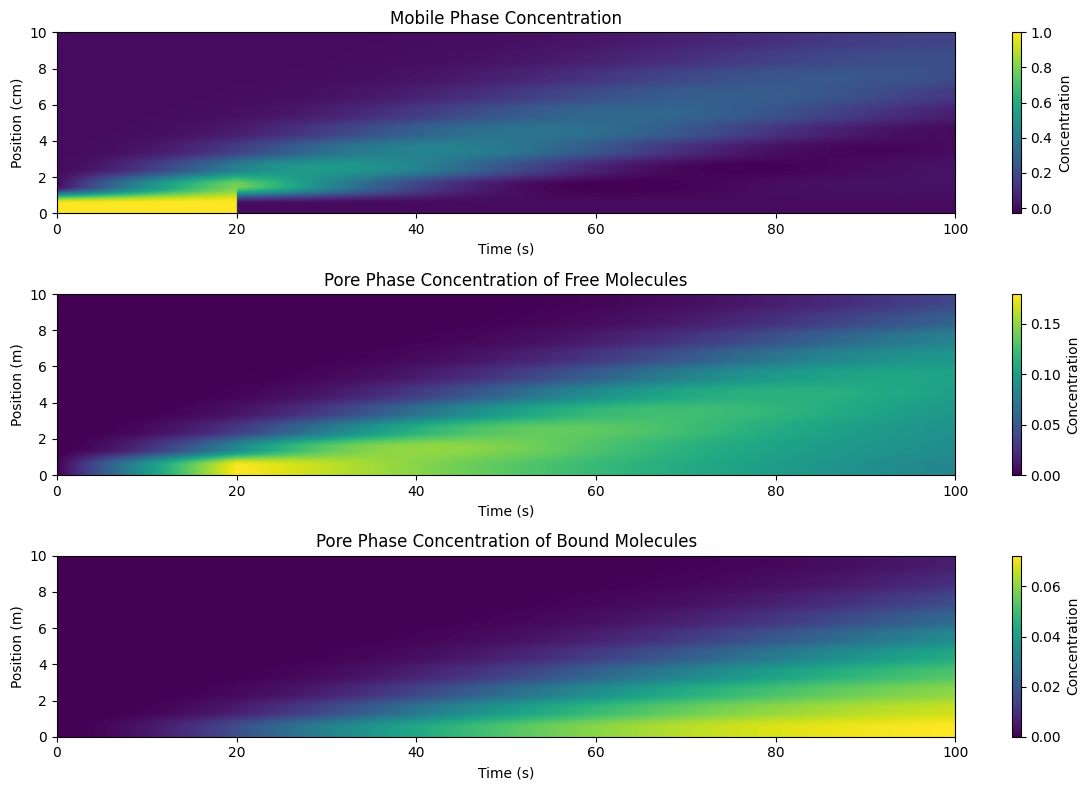

In [ ]:
## Filtration baséée sur la taille de la molécule

class Filtration:
    def __init__(self, feed, filter_size):
        self.feed = feed
        self.filter_size = filter_size

class Chromatography(Filtration):
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity):
        super().__init__(feed, filter_size)

        self.L = L # longueur de la colonne (cm)
        self.T = T # temps de la chromatographie
        self.v = v # velocité linéaire de la phase mobile (m/s)
        self.D = D # coefficient de diffusion  (m^2/s)
        self.Nx = Nx # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration # durée d'alimentation
        self.pulse_concentration = pulse_concentration # concentration de l'alimentation
        self.target_molecule = target_molecule # molécule d'interêt
        self.particle_size = particle_size
        self.molecule_size = molecule_size
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity
        self.affinity = affinity

        self.z = np.linspace(0, L, Nx)

        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        # Transport and production rates
        self.R = self.calculate_R
        self.Rp = self.calculate_Rp
        self.Rq = self.calculate_Rq

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_R(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rp(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rq(self, c, cp, q):
        return self.affinity * (cp - q) * (self.particle_size / (self.particle_size + self.molecule_size))

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.R(self.c, self.cp, self.q)
            dcp_dt = self.Rp(self.c, self.cp, self.q)
            dq_dt = self.Rq(self.c, self.cp, self.q)

            self.c += dc_dt * self.dt
            self.cp += dcp_dt * self.dt
            self.q += dq_dt * self.dt

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()

    def plot_results(self,nbr_simu):
        time_points = np.linspace(0, self.T, len(self.c_history))

        size  = self.molecule_size * i * 10
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.title(f'Mobile Phase Concentration for molecule size {size}')
        plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(2, 1, 2)
        plt.title(f'Pore Phase Concentration of Free molecule size {self.charges[i]}')
        plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()


# Parameters
L = 10
T = 100.0
v = 0.1
D = 0.01
Nx = 10
Nt = 10000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0
particle_size = .01  # Example particle size
molecule_size = 0.0001  # Example molecule size
temperature = 298.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 1  # Example solvent viscosity (arbitrary units)
affinity = 0.01  # Example affinity constant
size = [.0001,.001,.01]

# Instantiate and run chromatography
chromatography = Chromatography(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity)
chromatography.perform_chromatography()
chromatography.plot_result()

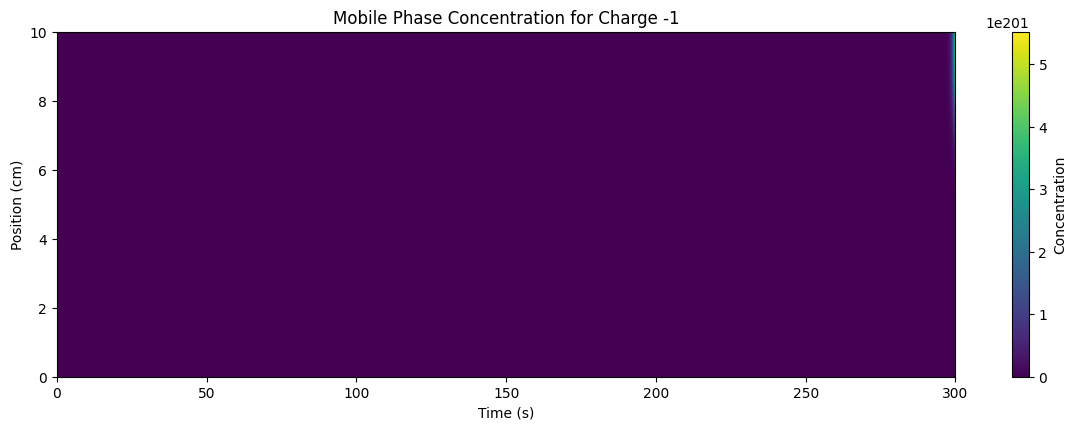

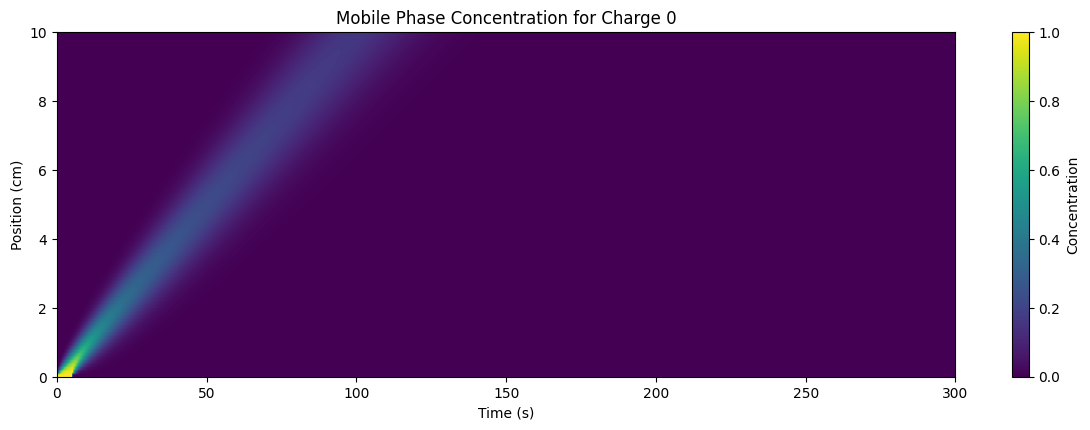

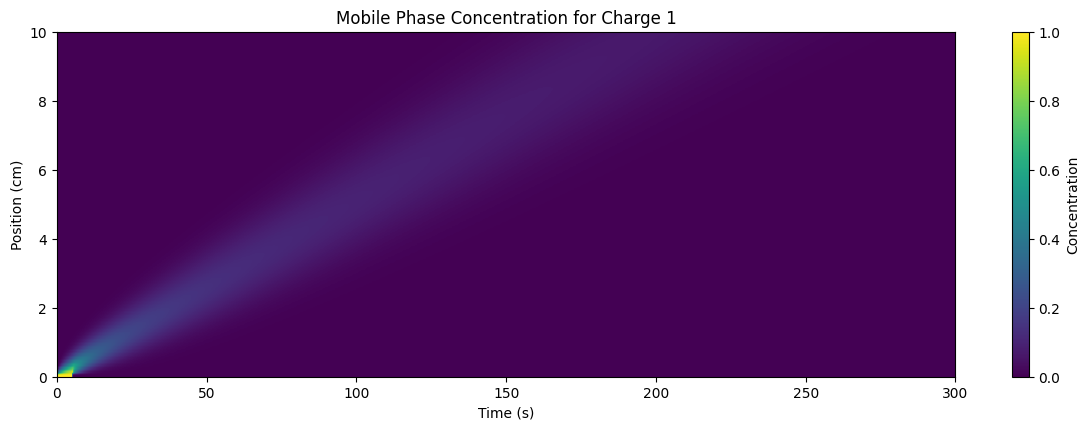

In [ ]:
## Filtration baséée sur la charge de la molécule

import numpy as np
import matplotlib.pyplot as plt

class ChromatographySimulation:
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, charges, retention_factors, temperature,solvent_viscosity):
        self.L = L  # Length of the column
        self.T = T  # Total time
        self.v = v  # Linear mobile phase velocity
        self.D = D  # Diffusion coefficient
        self.Nx = Nx  # Number of spatial grid points
        self.Nt = Nt  # Number of time steps
        self.dx = L / Nx  # Spatial step size
        self.dt = T / Nt  # Time step size
        self.pulse_duration = pulse_duration
        self.pulse_concentration = pulse_concentration
        self.charges = charges  # List of charges of the molecules
        self.retention_factors = retention_factors  # Retention factors for the molecules
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity

        self.c = np.zeros((len(charges), Nx))  # Mobile phase concentration for each molecule
        self.cp = np.zeros((len(charges), Nx))  # Pore phase concentration of free molecules for each molecule

        self.z = np.linspace(0, L, Nx)
        self.c_history = []
        self.cp_history = []
    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def R(self, c, cp, charge, retention_factor):
        return  (c - cp) * charge

    def simulate(self):
        for n in range(self.Nt):
            t = n * self.dt
            for i in range(len(self.charges)):
                charge = self.charges[i]
                retention_factor = self.retention_factors[i]

                J = -self.D * np.gradient(self.c[i], self.dx)
                N = self.v * self.c[i] + J

                dc_dt = -np.gradient(N, self.dx) - self.R(self.c[i], self.cp[i], charge, retention_factor)
                dcp_dt = self.R(self.c[i], self.cp[i], charge, retention_factor)

                self.c[i] += dc_dt * self.dt
                self.cp[i] += dcp_dt * self.dt

                if t <= self.pulse_duration:
                    self.c[i][0] = self.pulse_concentration

                else:
                    self.c[i][0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())The binding isotherm (often nonlinear) describes how the target molecules interact with the ligands.

    def plot_results(self):

        for i in range(len(self.charges)):
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 1, 1)
            plt.title(f'Mobile Phase Concentration for Charge {self.charges[i]}')
            plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
            plt.colorbar(label='Concentration')
            plt.xlabel('Time (s)')
            plt.ylabel('Position (cm)')

            plt.tight_layout()
            plt.show()

# Parameters
L = 10.0
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 1000
pulse_duration = 5
pulse_concentration = 1
charges = [-1, 0, 1]  # Example charges for different molecules
retention_factors = [0.1, 0.1, 0.1]  # Example retention factors
solvent_viscosity = 0.9
temperature = 298.15

# Create simulation instance
simulation = ChromatographySimulation(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, charges, retention_factors, temperature, solvent_viscosity)
simulation.simulate()
simulation.plot_results()

Simulation progress: 0.0%
Simulation time: 0.0s
Phys time: 0.06844472885131836s
Simulation progress: 10.0%
Simulation time: 3.0s
Phys time: 13.182373046875s
Simulation progress: 20.0%
Simulation time: 6.0s
Phys time: 19.55939745903015s
Simulation progress: 30.0%
Simulation time: 9.0s
Phys time: 24.024834394454956s
Simulation progress: 40.0%
Simulation time: 12.0s
Phys time: 31.592766046524048s
Simulation progress: 50.0%
Simulation time: 15.0s
Phys time: 36.11041760444641s
Simulation progress: 60.0%
Simulation time: 18.0s
Phys time: 42.699464559555054s
Simulation progress: 70.0%
Simulation time: 21.0s
Phys time: 46.97693729400635s
Simulation progress: 80.0%
Simulation time: 24.0s
Phys time: 51.21340322494507s
Simulation progress: 90.0%
Simulation time: 27.0s
Phys time: 57.72941541671753s
Total Computaion time: 62.22264790534973


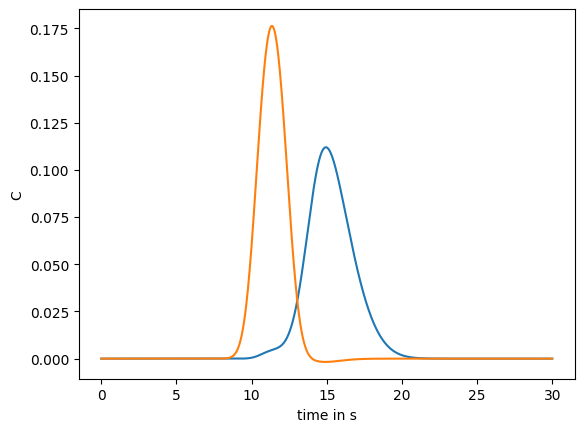

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Aug 15 18:32:32 2020

@author: Benedict
"""

# -*- coding: utf-8 -*-
"""
Created on Sat Aug 15 17:15:14 2020

@author: Benedict
"""

import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import time
#column Parameters
L = 15 #cm
tmax = 30 #s
u_inter = 1.5 #cm/s
epsilon = 0.72
t_slug=2
keff=0.01
Rp=0.0025
Lambda=2

const_1 = (1-epsilon)/epsilon#constants to reduce computations
const_2 = 3/Rp #constants to reduce computations
D_ax = 0.05 #cm^2/s

#Numeric Parameters
dt = 0.005 #s
dx = 0.1 #cm
N=int(L/dx)
M=int(tmax/dt)


#Components
isotherme='Langmuir'
C=2 # Number of Components
params=np.ndarray(C,dict)

if isotherme=='Langmuir':
    params[0]={'KL': 1,'qmax': 0.5,'c_in':0.2}
    params[1]={'KL': 0.1,'qmax': 0.5,'c_in':0.2}

if isotherme=='Henry':
    params[0]={'Kh': 1,'c_in':1}
    params[1]={'Kh': 0.1,'c_in':1}

if isotherme=='SMA':
    params[0]={'Ksma': 3,'sigma':2,'ny':2,'c_in':2}
    params[1]={'Ksma': 1,'sigma':4,'ny':3,'c_in':2}

#Memory
concentration=np.zeros((C,N))
q=np.zeros((C,N))
if isotherme=='SMA':
    c_salt=np.zeros(N)
    c_salt_save = np.zeros(N)
concentration_s=np.zeros((C,N))
q_s=np.zeros((C,N))

#visualiation
plot=np.zeros((C,M))
t=[i*dt for i in range(M)]
def compute_dc_dx(c_i,i):
    return (c_i[i+1]-c_i[i-1])/(2*dx)

def compute_dc2_dx2(c_i,i):
    return (c_i[i+1]+c_i[i-1]-2*c_i[i])/(dx*dx)

def compute_cp_LG(c,q,i,params):
    A=np.ndarray((C,C))
    D=np.ndarray(C)

    for k in range(C):
        for l in range(C):
            if k==l:
                A[k][l] = params[l]['KL']*(q[k][i]-params[l]['qmax'])
            else:
                A[k][l]=q[k][i]*params[l]['KL']
        D[k]=-q[k][i]
    return D.dot(np.linalg.inv(A))

def compute_cp_SMA(q,k,i,params,csalt):
    tmp=0
    for r in range(C):
        tmp+=q[r][i]*(params[r]['ny']+params[r]['sigma'])
    return (q[k][i]/params[k]['Ksma'])*(csalt/(Lambda-tmp))**params[k]['ny']

#Main Computation

if __name__=='__main__':
    start=time.time()
    #Initial conditions
    for k in range(C):
        concentration[k][0]=params[k]['c_in']
    if isotherme=='SMA':
        c_salt[0]=1

    #Main Looper
    for i in range(M):
       concentration_s=cp.deepcopy(concentration)
       q_s=cp.deepcopy(q)

       if isotherme=='SMA':
           c_salt_save = cp.deepcopy(c_salt)

       if isotherme=='Langmuir':
           for l in range(1,N-1):
               tmp=compute_cp_LG(concentration_s,q_s,l,params)
               for k in range(C):
                   concentration[k][l]+=(D_ax*compute_dc2_dx2(concentration_s[k],l)-u_inter*compute_dc_dx(concentration_s[k],l)-const_1*const_2*keff*(concentration_s[k][l]-tmp[k]))*dt
                   q[k][l]+=const_1*const_2*keff*(concentration_s[k][l]-tmp[k])*dt

       if isotherme=='Henry':
           for l in range(1,N-1):
               for k in range(C):
                   concentration[k][l]+=(D_ax*compute_dc2_dx2(concentration_s[k],l)-u_inter*compute_dc_dx(concentration_s[k],l)-const_1*const_2*keff*(concentration_s[k][l]-q[k][l]/params[k]['Kh']))*dt
                   q[k][l]+=const_1*const_2*keff*(concentration_s[k][l]-q[k][l]/params[k]['Kh'])*dt

       if isotherme=='SMA':
           for l in range(1,N-1):
               c_salt[l]+=(D_ax*compute_dc2_dx2(c_salt_save,l)-u_inter*compute_dc_dx(c_salt_save,l))*dt
               for k in range(C):
                   concentration[k][l]+=(D_ax*compute_dc2_dx2(concentration_s[k],l)-u_inter*compute_dc_dx(concentration_s[k],l)-const_1*const_2*keff*(concentration_s[k][l]-compute_cp_SMA(q,k,l,params,c_salt[l])))*dt
                   q[k][l]+=const_1*const_2*keff*(concentration_s[k][l]-compute_cp_SMA(q,k,l,params,c_salt[l]))*dt

        #boundary conditions
       for k in range(C):
           if i*dt<t_slug:
               concentration[k][0]=params[k]['c_in']
           else:
               concentration[k][0]=0
           concentration[k][-1]=concentration[k][-2]
       if isotherme=='SMA':
           c_salt[-1]=c_salt[-2]

        #add detecotor output for visualization
       for k in range(C):
           plot[k][i]=concentration[k][-2]
       if 100*i/M%10==0:
        print('Simulation progress: '+str(100*i/M)+'%')
        print('Simulation time: '+str(i*dt)+'s')
        print('Phys time: '+str(time.time()-start)+'s')

    print('Total Computaion time: '+str(time.time()-start))
    #visualization
    plt.xlabel('time in s')
    plt.ylabel('C')
    for k in range(C):
        plt.plot(t,plot[k,:])



In [2]:
import numpy as np

class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, particle_size, temperature, solvent_viscosity,
                 affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size, elution_volume, n_components=1):

        super().__init__(feed=feed, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = np.array(pulse_concentration)  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = np.array(molecule_size)  # taille des molécules
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = np.array(affinity)  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand
        self.pI = np.array(pI)  # point isoélectrique des molécules
        self.elution_volume = elution_volume
        self.n_components = n_components  # Nombre de composants

        # Discrétisation spatiale et radiale
        self.z = np.linspace(0, L, Nx)
        self.r = np.linspace(0, particle_size / 2, Nx)  # Radial discretization
        self.dr = self.r[1] - self.r[0]

        # Concentrations dans les phases mobile, dans les pores et liée
        self.c = np.zeros((Nx, n_components))
        self.cp = np.zeros((Nx, Nx, n_components))
        self.q = np.zeros((Nx, n_components))

        # Conditions initiales
        self.c0 = lambda z: np.zeros((len(z), n_components))
        self.cp0 = lambda z: np.zeros((len(z), len(z), n_components))
        self.q0 = lambda z: np.zeros((len(z), n_components))

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp[:, -1, :].copy()]  # Stocke uniquement la concentration au centre des particules
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant ainsi que de la taille de la molécule
        Formule dérivée de la loi de Stijes-Einstein
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores
        """
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        """
        Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
        """
        ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
        surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
        max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
        return max_ligand_density

    def calculate_affinity_factor(self, i):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand pour un composant donné
        :param i: index du composant
        :return: facteur d'affinité ajusté.
        """
        affinity_base = self.affinity[i] * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
        charge_effect = 1 if abs(self.pH - self.pI[i]) < 1 else 0.8
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity)) * charge_effect
        return affinity_

    def calculate_R(self, c, cp, q, i):
        """
        Calcule le taux de transport du volume de liquide mobile (bulk phase) au volume des pores des particules
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param i: index du composant
        :return: terme de réaction R
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp, i)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q, i):
        """
        Calcule le taux de transport des molécules dans le volume libre (unbound ou free) à l'intérieur des pores des particules
        Représente les molécules entrant ou sortant de l'espace poreux où elles ne sont pas liées à la phase stationnaire
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param i: index du composant
        :return: terme de réaction Rp
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = self.calculate_rp(c, cp, i)
        rq = self.calculate_rq(cp, q, i)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q, i):
        """
        Calcule le taux de transport des molécules vers l'état lié dans le volume des pores de la particule.
        Correspond à l'adsorption (ou à la désorption) des molécules sur (ou depuis) ​​les ligands dans les pores de la particule
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param i: index du composant
        :return: terme de réaction Rq
        """
        rq = self.calculate_rq(cp, q, i)
        return rq

    def calculate_rp(self, c, cp, i):
        """
        Calcule le terme de réaction rp pour la phase mobile
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param i: index du composant
        :return: terme de réaction rp
        """
        affinity_factor = self.calculate_affinity_factor(i)
        return affinity_factor * (c[:, i] - cp[:, -1, i])

    def calculate_rq(self, cp, q, i):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param i: index du composant
        :return: terme de réaction rq
        """
        affinity_factor = self.calculate_affinity_factor(i)
        return affinity_factor * (cp[:, -1, i] - q[:, i])

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx, axis=0)
            N = self.v * self.c + J

            for i in range(self.n_components):
                dc_dt = -np.gradient(N[:, i], self.dx) - self.calculate_R(self.c, self.cp, self.q, i)
                dcp_dt = self.calculate_Rp(self.c, self.cp, self.q, i)
                dq_dt = self.calculate_Rq(self.c, self.cp, self.q, i)

                # Mise à jour des concentrations
                self.c[:, i] = np.clip(self.c[:, i] + dc_dt * self.dt, 0, np.inf)
                self.cp[:, :, i] = np.clip(self.cp[:, :, i] + dcp_dt[:, None] * self.dt, 0, np.inf)
                self.q[:, i] = np.clip(self.q[:, i] + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0, :] = self.pulse_concentration
            else:
                self.c[0, :] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp[:, -1, :].copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        time_points = np.linspace(0, self.T, len(self.c_history))

        size  = self.molecule_size * i * 10
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.title(f'Mobile Phase Concentration for molecule size {size}')
        plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(2, 1, 2)
        plt.title(f'Pore Phase Concentration of Free molecule size {self.charges[i]}')
        plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()

n_components = 3  # Par exemple, pour trois différents solutés

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=[1, 0.5, 0.3],  # Différentes concentrations pour chaque composant
    feed=feed,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=[0.01, 0.02, 0.03],  # Différentes affinités pour chaque composant
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI=[7.5, 6.5, 8.0],  # Différents points isoélectriques pour chaque composant
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_size=[0.001, 0.0015, 0.002],  # Différentes tailles de molécules
    elution_volume=elution_volume,
    n_components=n_components  # Ajout de l'argument n_components
)

chromato.perform_chromatography()
chromato.plot_result()


NameError: name 'Filtration' is not defined